human mouse
=== Value summary paper
human  to  mouse
Ortho perf at 100, 50, 10, 1
11271.0 6329.0 1303.0 118.0
=
Model perf at 100, 50, 10, 1
14951.0 7532.0 1497.0 135.0
mouse human
=== Value summary paper
mouse  to  human
Ortho perf at 100, 50, 10, 1
11271.0 5922.0 1242.0 110.0
=
Model perf at 100, 50, 10, 1
14507.0 7393.0 1510.0 142.0
Status plot created


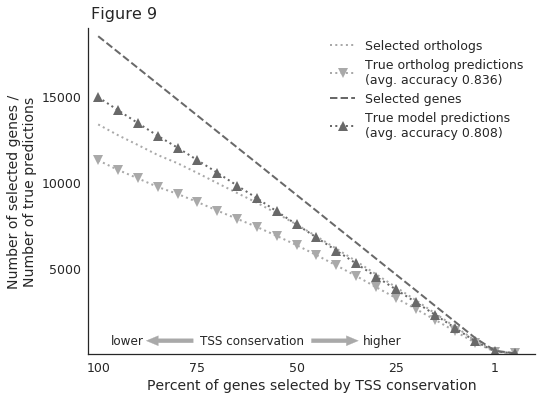

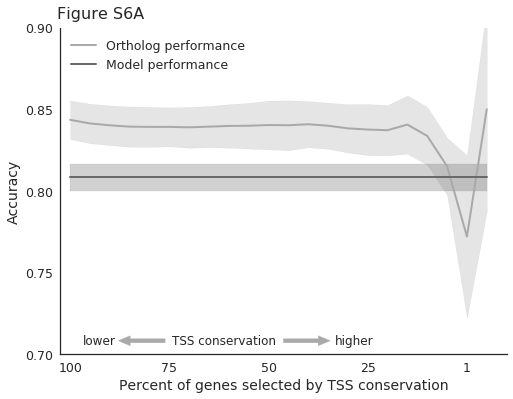

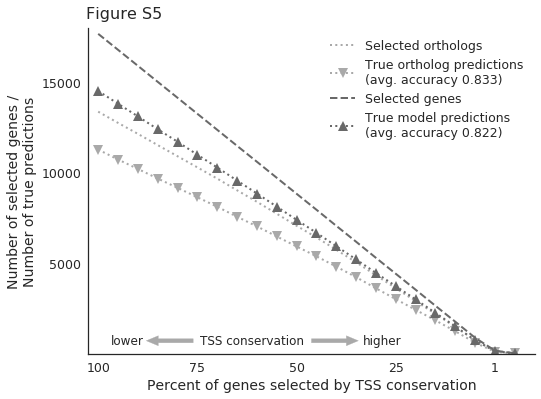

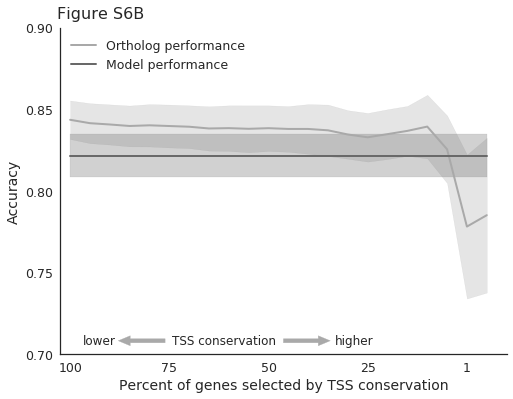

In [1]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

# What is this?
# Plot model performance evaluated
# on gene subsets selected by core
# promoter conservation

date = '20180429'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_v9.h5')

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

run_exec_status = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def exec_status():
    cache_data = os.path.join(cache_dir, '{}_plot_perfcomp_tss.pck'.format(date))
    fullmodel = 'can'
    if not run_exec_status:
        return False
    if os.path.isfile(cache_data):
        model_perf = pck.load(open(cache_data, 'rb'))
    else:
        model_perf = collect_ortho_perf(ortho_pred, fullmodel)
        model_perf = collect_model_stat_perf(stat_file, model_perf, 'pos', fullmodel)
        with open(cache_data, 'wb') as out:
            print('Writing cache file for status line plot')
            pck.dump(model_perf, out)
    idx_0 = 0
    idx_50 = 10
    idx_90 = 18
    idx_99 = 20
    figure_keys = {('human', 'mouse'): ('9', 'main', 'S6A'),
                   ('mouse', 'human'): ('S5', 'supp', 'S6B')}
    for (spec_a, spec_b), perf in model_perf.items():
        print(spec_a, spec_b)
        fk, subfolder, sfk = figure_keys[(spec_a, spec_b)]
        orth_perf = perf['data_orth_pair']['positives'].mean(axis=0).round(decimals=0)
        orth_max = perf['data_orth_pair']['relevant'].median(axis=0)
        
        orth_acc_mean = perf['data_orth_pair']['accuracy'].mean(axis=0)
        orth_acc_std = perf['data_orth_pair']['accuracy'].std(axis=0)
        
        orth_acc_avg = orth_acc_mean.mean().round(3)
        
        datavalues = [orth_max, orth_perf]
        linecolors = ['darkgrey', 'darkgrey']
        linestyles = ['dotted', 'dotted']
        
        spec_color = plot_colors['species'][spec_b]['rgb']
        model_perf = perf['data_crp_{}_wg'.format(fullmodel)]['positives'].mean(axis=0).round(decimals=0)
        model_max = perf['data_crp_{}_wg'.format(fullmodel)]['relevant'].median(axis=0)
        
        model_acc_mean = perf['data_crp_{}_wg'.format(fullmodel)]['accuracy'].mean(axis=0)
        model_acc_std = perf['data_crp_{}_wg'.format(fullmodel)]['accuracy'].std(axis=0)
        
        model_acc_avg = model_acc_mean.mean().round(3)
        
        
        datavalues.extend([model_max, model_perf])
        
        # summary of values for paper
        print('=== Value summary paper')
        print(spec_a, ' to ', spec_b)
        print('Ortho perf at 100, 50, 10, 1')
        print(orth_perf[idx_0], orth_perf[idx_50], orth_perf[idx_90], orth_perf[idx_99])
        print('=')
        print('Model perf at 100, 50, 10, 1')
        print(model_perf[idx_0], model_perf[idx_50], model_perf[idx_90], model_perf[idx_99])
                
        #linecolors.extend([spec_color, spec_color])
        linecolors.extend(['dimgrey', 'dimgrey'])
        linestyles.extend(['dashed', 'dotted'])
        linelabels = ['Selected orthologs', 'True ortholog predictions\n(avg. accuracy {})'.format(orth_acc_avg),
                      'Selected genes', 'True model predictions\n(avg. accuracy {})'.format(model_acc_avg)]
        markershapes = ['', 'v', '', '^']
         
        plot_title = 'Gene expression prediction: {}-to-{} model'.format(spec_a, spec_b)
        
        y_max = datavalues[2].max()
        if np.round(y_max, -3) < y_max:
            y_max = np.round(y_max, -3) + 1000
        else:
            y_max = np.round(y_max, -3)
        
        fig, exart = plot_perf_linechart(datavalues, [orth_acc_mean, model_acc_mean], y_max,
                                         linelabels, linecolors, linestyles,
                                         markershapes,'Number of selected genes /\nNumber of true predictions',
                                         'Percent of genes selected by TSS conservation',
                                         'Figure {}'.format(fk))

        if save_figures:
            outname = 'fig_{}_{}-{}_testperf_tss'.format(fk, spec_a, spec_b)
            
            outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            
            outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
            
            outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
        
        fig, exart = plot_acc_linechart([orth_acc_mean, model_acc_mean],
                                        [orth_acc_std, model_acc_std],
                                        ['Ortholog performance', 'Model performance'],
                                        ['darkgrey', 'dimgrey'],
                                        'Percent of genes selected by TSS conservation',
                                        'Figure {}'.format(sfk))
        
        if save_figures:
            subfolder = 'supp'
            outname = 'fig_{}_{}-{}_testperf_tss'.format(sfk, spec_a, spec_b)
            
            outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            
            outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
            
            outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                        
    return True
       

def plot_perf_linechart(datavals, accvals, ylim,
                        linelabels, linecolor, linestyle, linemarker,
                        ylabel, xlabel, title):
    """
    """    
    fig, ax = plt.subplots(figsize=(8, 6))
    extra_artists = []
    ax.set_xlim(-0.5, datavals[0].size)
    ax.set_ylim(-1, ylim)
    ax.set_yticks([5000, 10000, 15000])
    ax.set_yticklabels(['5000', '10000', '15000'])
    ax.set_xticks([0, 5, 10, 15, datavals[0].size - 2])
    ax.set_xticklabels(['100', '75', '50', '25', '1'])
    
    x_values = np.arange(datavals[0].size)

    handles = []
    for y_values, label, color, style, marker in zip(datavals,
                                                     linelabels,
                                                     linecolor,
                                                     linestyle,
                                                     linemarker):
        line = ax.plot(x_values, y_values.values, linestyle=style, color=color, marker=marker,
                       markersize=10, linewidth=2, label=label)
        handles.append(line)
        
    handles, labels = ax.get_legend_handles_labels()
    plt.legend()    
    
    extra_artists = []
    
    ax.annotate(s='lower', xy=(0.05, 0.03), xycoords='axes fraction',
                fontsize=12)
    
    ax.annotate(s='', xy=(0.13, 0.04), xytext=(0.235, 0.04), xycoords='axes fraction',
                arrowprops={'width': 4, 'headwidth': 10,
                            'headlength': 12, 'color': 'darkgrey'})
    
    ax.annotate(s='TSS conservation', xy=(0.25, 0.03), xycoords='axes fraction',
                fontsize=12)
    
    ax.annotate(s='', xy=(0.605, 0.04), xytext=(0.5, 0.04), xycoords='axes fraction',
                arrowprops={'width': 4, 'headwidth': 10,
                            'headlength': 12, 'color': 'darkgrey'})
    
    ax.annotate(s='higher', xy=(0.615, 0.03), xycoords='axes fraction',
                fontsize=12)
    
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    tt = ax.set_title(title, fontsize=16)
    tt.set_position([0.08, 1.01])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
         
    return fig, extra_artists


def plot_acc_linechart(mean_data, std_data, linelabels, linecolors, xlabel, title):
    """
    """    
    fig, ax = plt.subplots(figsize=(8, 6))
    extra_artists = []
    ax.set_xlim(-0.5, mean_data[0].size)
    ax.set_ylim(0.7, 0.9)
    ax.set_yticks(np.arange(0.7, 0.95, step=0.05))
    ax.set_xticks([0, 5, 10, 15, mean_data[0].size - 2])
    ax.set_xticklabels(['100', '75', '50', '25', '1'])
    
    x_values = np.arange(mean_data[0].size)

    handles = []
    for y_mean, y_std, label, color in zip(mean_data,
                                           std_data,
                                           linelabels,
                                           linecolors):
        
        line = ax.plot(x_values, y_mean, linestyle='solid',
                       color=color, linewidth=2, label=label, zorder=3)
        shade = ax.fill_between(x_values,
                                y_mean - y_std,
                                y_mean + y_std,
                                color=color,
                                alpha=0.3,
                                zorder=1)
        
    ax.legend(loc='upper left')    
        
    ax.annotate(s='lower', xy=(0.05, 0.03), xycoords='axes fraction',
                fontsize=12)
    
    ax.annotate(s='', xy=(0.13, 0.04), xytext=(0.235, 0.04), xycoords='axes fraction',
                arrowprops={'width': 4, 'headwidth': 10,
                            'headlength': 12, 'color': 'darkgrey'})
    
    ax.annotate(s='TSS conservation', xy=(0.25, 0.03), xycoords='axes fraction',
                fontsize=12)
    
    ax.annotate(s='', xy=(0.605, 0.04), xytext=(0.5, 0.04), xycoords='axes fraction',
                arrowprops={'width': 4, 'headwidth': 10,
                            'headlength': 12, 'color': 'darkgrey'})
    
    ax.annotate(s='higher', xy=(0.615, 0.03), xycoords='axes fraction',
                fontsize=12)
    
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    tt = ax.set_title(title, fontsize=16)
    tt.set_position([0.09, 1.01])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    return fig, extra_artists



def collect_model_stat_perf(fpath, data_collect, scenario, model_type):
    """
    """
    with pd.HDFStore(fpath, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/'.join(['', scenario, model_type])) and k.endswith('/cons')]
        for k in load_keys:
            md = hdf[k.replace('/cons', '/metadata')]
            spec_a = md.loc['target_spec',:][0]
            spec_b = md.loc['query_spec',:][0]
            perf = hdf[k]
            
            if (spec_a, spec_b) not in [('human', 'mouse'), ('mouse', 'human')]:
                continue
            model = 'data_crp_{}_wg'.format(model_type)
            if (spec_a, spec_b) not in data_collect:
                data_collect[(spec_a, spec_b)] = {model: {'positives': None,
                                                          'relevant': None,
                                                          'accuracy': None}}
            relevant = perf.loc[['relevant'], :]
            positives = perf.loc[['positives'], :]
            accuracy = perf.loc[['accuracy'], :]
            
            model_perf = data_collect[(spec_a, spec_b)][model]
            if model_perf['relevant'] is None:
                model_perf['relevant'] = relevant
                model_perf['positives'] = positives
                model_perf['accuracy'] = accuracy
                data_collect[(spec_a, spec_b)][model] = model_perf
            else:
                relevant = pd.concat([model_perf['relevant'], relevant], ignore_index=True, axis=0)
                positives = pd.concat([model_perf['positives'], positives], ignore_index=True, axis=0)
                accuracy = pd.concat([model_perf['accuracy'], accuracy], ignore_index=True, axis=0)
                model_perf['relevant'] = relevant
                model_perf['positives'] = positives
                model_perf['accuracy'] = accuracy
                data_collect[(spec_a, spec_b)][model] = model_perf
    return data_collect


def collect_ortho_perf(fpath, model):
    """
    """
    collector = dict()
    with pd.HDFStore(fpath, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/pos/pair') and k.endswith('/cons')]
        for k in load_keys:
            parts = k.split('/')
            spec_a, spec_b = parts[3], parts[4]
            if (spec_a, spec_b) not in [('mouse', 'human'), ('human', 'mouse')]:
                continue
            perf = hdf[k]
                        
            if (spec_a, spec_b) not in collector:
                collector[(spec_a, spec_b)] = {'data_orth_pair': {'relevant': None,
                                                                  'positives': None,
                                                                  'accuracy': None},
                                               'data_crp_{}_wg'.format(model): {'positives': None,
                                                                                'relevant': None,
                                                                                'accuracy': None}}
            relevant = perf.loc[['relevant'], :]
            positives = perf.loc[['positives'], :]
            accuracy = perf.loc[['accuracy'], :]
            
            orth_perf = collector[(spec_a, spec_b)]['data_orth_pair']
            if orth_perf['relevant'] is None:
                orth_perf['relevant'] = relevant
                orth_perf['positives'] = positives
                orth_perf['accuracy'] = accuracy
                collector[(spec_a, spec_b)]['data_orth_pair'] = orth_perf
            else:
                relevant = pd.concat([orth_perf['relevant'], relevant], ignore_index=True, axis=0)
                positives = pd.concat([orth_perf['positives'], positives], ignore_index=True, axis=0)
                accuracy = pd.concat([orth_perf['accuracy'], accuracy], ignore_index=True, axis=0)
                orth_perf['relevant'] = relevant
                orth_perf['positives'] = positives
                orth_perf['accuracy'] = accuracy
                collector[(spec_a, spec_b)]['data_orth_pair'] = orth_perf
    return collector               
                

execd = exec_status()
if execd:
    print('Status plot created')